In [27]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker
import random
import os
from functools import singledispatch
from typing import Union
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import Parameter

torch.set_printoptions(precision=10)

# Importing Data - From USB
if os.path.exists("F:/venv code/Y3 Work/Fibres/MATLAB Files"):
    PIM_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Modes.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes
    PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

    beta_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Beta.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.float)

    print("Files imported from USB.")

# Importing Data - From Kaggle
elif os.path.exists("/kaggle/input/fibre-data"):
    PIM_data = sc.io.loadmat("/kaggle/input/fibre-data/Modes.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes
    PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

    beta_data = sc.io.loadmat("/kaggle/input/fibre-data/Beta.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.cfloat)

    print("Files imported from Kaggle database.")

else:
    print("No files found.")

# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

if torch.cuda.is_available():
    devNumber = torch.cuda.current_device()
    print(f"The current device number is {devNumber}")

    dev_name = torch.cuda.get_device_name(devNumber)
    print(f"GPU is {dev_name}")
else:
    print(f"No GPU available.")

Files imported from USB.
Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [15]:
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def beta_matrix(length=0):
    """New function to make the diagonal square matrix for PIM propagation in an MMF. Takes inputs from the CPU and will return a tensor on the GPU."""
    beta_data = beta_torch.cpu() # Needs imported data
    betas = []
    for i in range(len(beta_data)):
        beta = beta_data[i].item().real
        angle = length * beta
        z = torch.exp(1j * angle)
        betas.append(z)
    
    # Convert the list to an np.array()
    #betas = np.asarray(betas, dtype=np.complex64)
    # Convert the np.array to a torch.tensor()
    betas = torch.as_tensor(betas)

    # Make the tensor a square diagonal
    betas_diag = torch.diag(betas)

    return betas_diag

def beta_matrix_test(length=0):
    """Function to make the diagonal square matrix for PIM propagation in an MMF."""
    return torch.diag(torch.exp(1j*length*beta_torch.flatten()))

def pim_matrix():
    """Creates the real space to pim space conversion matrix. Generated using external data for each PIM's shape."""
    pim = torch.column_stack((PIMs_torch[0].flatten(),PIMs_torch[1].flatten()))
    no_pims = PIMs_torch.size()[0]
    for i in np.arange(2, no_pims, 1):
        pim = torch.column_stack((pim, PIMs_torch[i].flatten()))
    
    # transpose
    pim = pim.transpose(0,1)

    return pim

def real_matrix():
    """Creates the pim space to real space conversion matrix. Generated using external data for each PIM's shape, from the pim_matrix() function."""
    real = torch.transpose(torch.conj(pim_matrix()), dim0=0, dim1=1)

    return real

def TM(length=0):
    """Creates the transmission matrix for a MMF, assumed to be perfectly straight,
    of length=length."""
    TM_part1 = beta_matrix_test(length) @ pim_matrix()
    TM = real_matrix() @ TM_part1
    return TM

def propagate(field, length=0):
    """Function to propagate an input field through a segment of perfectly
    straight optical fibre of length=length."""
    field_vec = vectorise(field)
    field_out_vec = TM(length) @ field_vec
    field_out = unvectorise(field_out_vec, 31)
    return field_out

def loss_fn(output, target):
    return (output - target).abs().square().sum()

def loss_func(outputs, targets):
    """Loss function for multiple sets of training data."""
    loss = 0
    for i in range(len(outputs)):
        loss += (outputs[i] - targets[i]).abs().square().sum()
    loss /= len(outputs)
    return loss

In [13]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=(10,5))

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.065))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', '$\pi/2$', '$\pi$', '$3\pi/2$','$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

In [34]:
# Model Class
class LengthModel(nn.Module):

    def __init__(self, length=0.21):
        super(LengthModel, self).__init__()

        # Parameters
        self.length = nn.Parameter(data=torch.tensor([length], dtype=torch.float32, requires_grad=True))
    
    def forward(self, input_field):
        """Forward pass of the model."""
        length = self.length.item()
        output_field = propagate(input_field, self.length)
        return output_field

## Main Code

C:\Users\elija\AppData\Local\Temp\ipykernel_3540\1617462763.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_3540\1617462763.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


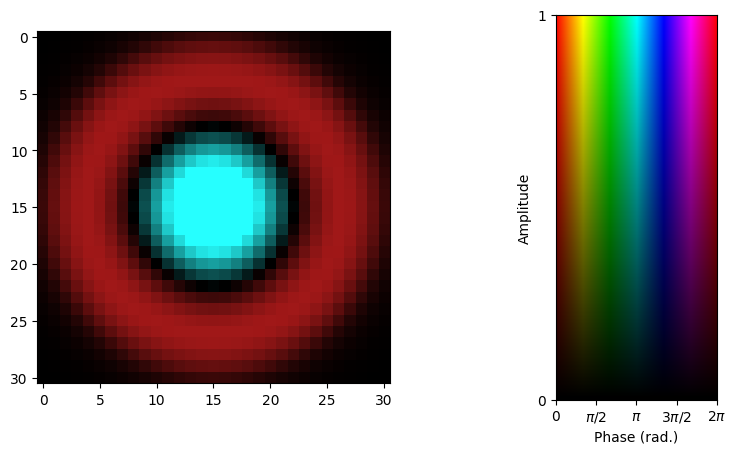

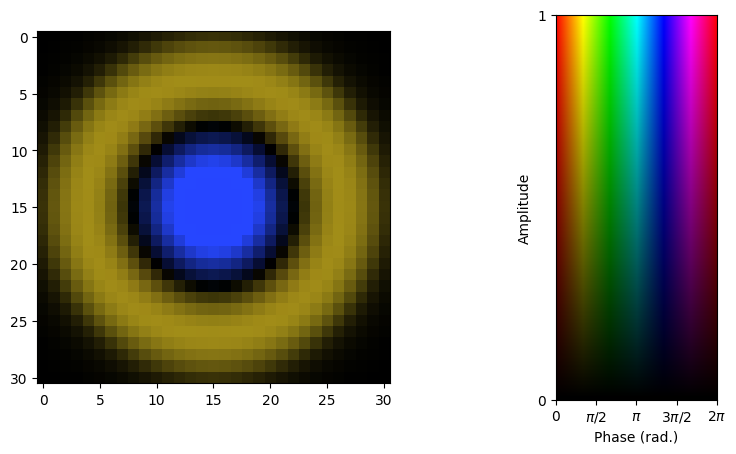

In [16]:
N = 20
field_in = PIMs_torch[N]
Field(field_in).visualise()

prop_dist = 1.1 #0.633e-6 / 1.457
#
prop_field = propagate(field_in, prop_dist)
Field(prop_field).visualise()

In [20]:
print(f"Phase Velocity of mode {N}: {beta[N].item()} m/s")
print(f"Phase change should be: {np.angle(np.exp(1j*beta[N].item()*prop_dist))} radians")

Phase Velocity of mode 20: 14456496.033630634 m/s
Phase change should be: 0.5271263474633857 radians


In [19]:
torch.angle(torch.exp(1j*prop_dist*beta_torch[N]))

tensor([0.8901])

In [30]:
print(beta[N])
print(beta_torch[N])

[14456496.03363063]
tensor([14456496.])


In [32]:
def plot_loss(n, dist, l_bound, u_bound, num_points):
    """Plots the loss function.
    n = Number of PIMs
    dist = Propagation distance
    l_bound, u_bound = Lower and upper bounds for the loss plot
    num_points = Number of points used in the loss plot"""
    
    model = LengthModel(dist)

    fields_in = PIMs_torch[0:n]

    fields_target = []
    for i in range(n):
        fields_target.append(model(fields_in[i]))

    # Plot loss function using the target data
    loss = []
    xs = torch.from_numpy(np.linspace(l_bound, u_bound, num_points))

    for i in range(xs.size()[0]):
        model = LengthModel(xs[i])
        fields_out = []
    
        for j in range(n):
            fields_out.append(model(fields_in[j]))
    
        loss.append(loss_func(fields_out, fields_target).cpu().detach().numpy())

        if i % 10 == 0:
            print(f"[{i}/{num_points}]")
            clear_output(wait=True)

    plt.plot(xs,loss)

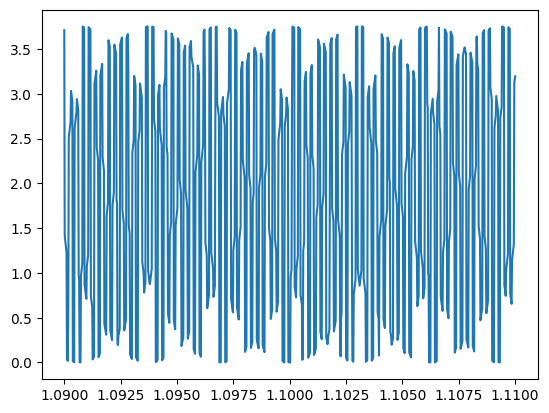

In [35]:
plot_loss(1, 1.1, 1.09, 1.11, 1001)

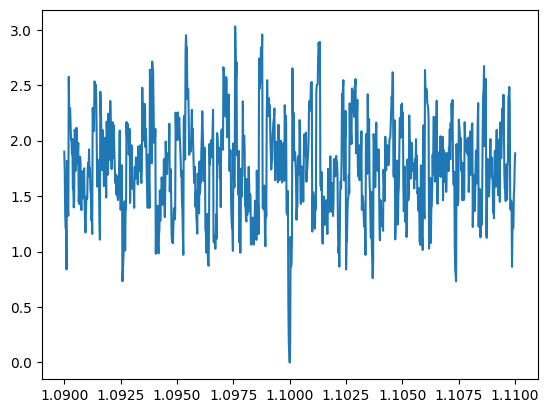

In [36]:
plot_loss(10, 1.1, 1.09, 1.11, 1001)

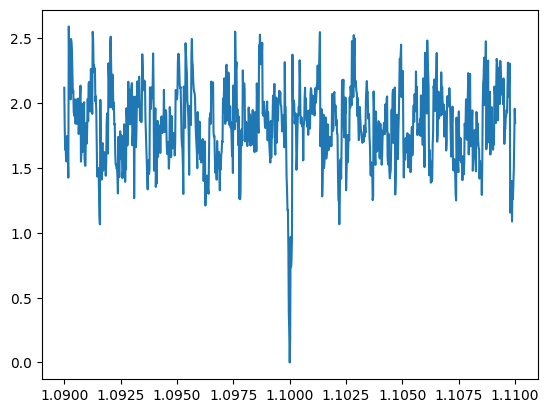

In [ ]:
plot_loss(42, 1.1, 1.09, 1.11, 1001)

### Optimiser Code
Find the initial guess and optimiser parameters that best find the correct fibre length.

In [37]:
# Functions to generate training data
data_model = LengthModel(1.1)
input_data = PIMs_torch[0:10]
target_data = []
for i in range(10):
    target_data.append(data_model(input_data[i]))



In [38]:
model = LengthModel(1.1005)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-5)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    output_data = []
    for i in range(10):
        output_data.append(model(input_data[i]))

    loss = loss_func(output_data, target_data)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, length: {model.length.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.length.item()}")


Epoch 0, Loss: 1.4289089441299438, length: 1.1005100011825562


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
# Training Loop
model = LengthModel(1.1005).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-5)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    fields_out = []
    for i in range(input_data.shape[0]):
        fields_out.append(model(input_data[i]))
    loss = loss_func(fields_out, target_data)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, length: {model.length.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.length.item()}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [3]:
def beta_matrix_test(length=0):
    """New function to make the diagonal square matrix for PIM propagation in an MMF. Takes inputs from the CPU and will return a tensor on the GPU."""
    beta_data = beta_torch # Needs imported data
    betas = []
    for i in range(len(beta_data)):
        beta = beta_data[i].real
        angle = length * beta * 1j
        z = torch.exp(angle)
        betas.append(z)
    
    # Convert the list to an np.array()
    #betas = np.asarray(betas, dtype=np.complex64)
    # Convert the np.array to a torch.tensor()
    betas = torch.as_tensor(betas)

    # Make the tensor a square diagonal
    betas_diag = torch.diag(betas)

    return betas_diag

In [ ]:
beta_matrix_test(1.5)

tensor([[0.9963+0.0855j, 0.0000+0.0000j, 0.0000+0.0000j,  ...,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.9897-0.1433j, 0.0000+0.0000j,  ...,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.8631+0.5050j,  ...,
         0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        ...,
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,  ...,
         0.8631+0.5050j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,  ...,
         0.0000+0.0000j, 0.9897-0.1433j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,  ...,
         0.0000+0.0000j, 0.0000+0.0000j, 0.9963+0.0855j]])

In [ ]:
beta_torch[0].real.item()

14429030.0

In [ ]:
x = np.linspace(0,20,21)
spinner = ['/','-','\\','|']
counter = 0
for i in range(x.size):
        if counter == 3:
            counter = 0
        else:
            counter += 1
        print(spinner[counter])

-
\
|
/
-
\
|
/
-
\
|
/
-
\
|
/
-
\
|
/
-


In [ ]:
def plot_loss(n, dist, l_bound, u_bound, num_points):
    """Plots the loss function.
    n = Number of PIMs
    dist = Propagation distance
    l_bound, u_bound = Lower and upper bounds for the loss plot
    num_points = Number of points used in the loss plot"""
    
    model = LengthModel(dist)

    fields_in = PIMs_torch[0:n]

    fields_target = []
    for i in range(n):
        fields_target.append(model(fields_in[i]))

    # Plot loss function using the target data
    loss = []
    xs = torch.from_numpy(np.linspace(l_bound, u_bound, num_points))

    for i in range(xs.size()[0]):
        model = LengthModel(xs[i])
        fields_out = []
    
        for j in range(n):
            fields_out.append(model(fields_in[j]))
    
        loss.append(loss_func(fields_out, fields_target).cpu().detach().numpy())

        # Spinner Code    
        spinner = ['/','-','\\','|']
        counter = 0
        if counter == 3:
            counter = 0
        else:
            counter += 1
        
        print(f"[{i}/{num_points}]  {spinner[counter]}")
        clear_output(wait=True)

    plt.plot(xs,loss)

In [ ]:
plot_loss(30, 1.1, 1.09, 1.11, 1001)

KeyboardInterrupt: 

In [6]:
def beta_matrix(length=0):
    """New function to make the diagonal square matrix for PIM propagation in an MMF. Takes inputs from the CPU and will return a tensor on the GPU."""
    beta_data = beta_torch.cpu() # Needs imported data
    betas = []
    for i in range(len(beta_data)):
        beta = beta_data[i].item().real
        angle = length * beta
        z = np.exp(1j * angle)
        betas.append(z)
    
    # Convert the list to an np.array()
    betas = np.asarray(betas, dtype=np.complex64)
    # Convert the np.array to a torch.tensor()
    betas = torch.as_tensor(betas)

    # Make the tensor a square diagonal
    betas_diag = torch.diag(betas)

    return betas_diag

In [4]:
beta_matrix_test(0.5)

tensor([[-0.1610-0.9870j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.4579+0.8890j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j, -0.5085+0.8611j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.5085+0.8611j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j, -0.4579+0.8890j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j, -0.1610-0.9870j]])

In [7]:
beta_matrix(0.5)

tensor([[-0.1610-0.9870j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.4579+0.8890j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j, -0.5085+0.8611j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.5085+0.8611j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j, -0.4579+0.8890j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j, -0.1610-0.9870j]])

In [ ]:
beta_torch[0]

tensor([14429030.+0.j])